https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Flatten, Dense, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import SGD, Adam
import matplotlib .pyplot as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score

from datetime import datetime
import cv2
import zipfile
import shutil
import os
import glob

from tensorflow.keras.applications import Xception, ResNet50
from tensorflow.keras.applications import InceptionV3, MobileNet

# Project-1

### 경로설정

In [4]:
#### Colab
root_dir = "/content"
data_root_dir = os.path.join(root_dir, "Chest_Xray_Pneumonia")
train_data_root_dir = os.path.join(data_root_dir, "train")
test_data_root_dir = os.path.join(data_root_dir, "test")
val_data_root_dir = os.path.join(data_root_dir, "val")

In [5]:
#### PC
root_dir = "content"
data_root_dir = os.path.join(root_dir, "Chest_Xray_Pneumonia")
train_data_root_dir = os.path.join(data_root_dir, "train")
test_data_root_dir = os.path.join(data_root_dir, "test")
val_data_root_dir = os.path.join(data_root_dir, "val")

### 데이터 가져오기

In [ ]:
#### Colab
from google.colab import drive

drive.mount("/content/")

shutil.copy(os.path.join("/content/drive/My Drive/", "Chest_Xray_Pneumonia.zip"), root_dir)

if os.path.exists(data_root_dir):
    shutil.rmtree(data_root_dir)

with zipfile.ZipFile(os.path.join(root_dir, "Chest_Xray_Pneumonia.zip")) as target_file:
    target_file.extractall(data_root_dir)

In [6]:
#### PC
if os.path.exists(data_root_dir):
    shutil.rmtree(data_root_dir)

with zipfile.ZipFile(os.path.join(root_dir, "Chest_Xray_Pneumonia.zip")) as target_file:
    target_file.extractall(data_root_dir)

### 정답 및 전체 데이터 갯수 확인

In [7]:
### 훈련데이터 갯수 
train_label_name_list = os.listdir(train_data_root_dir)

for label_name in train_label_name_list:
    print("train label :", label_name, ' =>',
          len(os.listdir(os.path.join(train_data_root_dir, label_name))))


print("==========================================================")
### 테스트 데이터 갯수
test_label_name_list = os.listdir(test_data_root_dir)

for label_name in train_label_name_list:
    print("test label :", label_name, ' =>',
          len(os.listdir(os.path.join(test_data_root_dir, label_name))))
    
print("==========================================================")
### val 데이터 갯수
val_label_name_list = os.listdir(val_data_root_dir)

for label_name in train_label_name_list:
    print("val label :", label_name, ' =>',
          len(os.listdir(os.path.join(val_data_root_dir, label_name))))

train label : NORMAL  => 1341
train label : PNEUMONIA  => 3875
test label : NORMAL  => 234
test label : PNEUMONIA  => 390
val label : NORMAL  => 8
val label : PNEUMONIA  => 8


### ImageShape 설정

In [9]:
img_width = 100 # Colab에서는 224로
img_height = 100

### ImageDataGenerotor를 이용하여 데이터 불러오기

In [10]:
train_data_gen = ImageDataGenerator(rescale = 1./255, validation_split=0.2)
val_data_gen = ImageDataGenerator(rescale = 1./255, validation_split=0.2)

test_data_gen = ImageDataGenerator(rescale = 1./255)

In [31]:
train_generator = train_data_gen.flow_from_directory(directory=train_data_root_dir,
                                  batch_size = 32, 
                                  target_size = (img_height, img_width),
                                  class_mode = "sparse",
                                  color_mode = "rgb",
                                    subset = "training") # train 폴더 설정

val_generator = val_data_gen.flow_from_directory(directory=train_data_root_dir, 
                                 batch_size = 32, 
                                 target_size = (img_height, img_width),
                                 class_mode = "sparse",
                                 color_mode = "rgb",
                                    subset = "validation") # validation폴더 설정

test_generator = test_data_gen.flow_from_directory(directory=test_data_root_dir, 
                                 batch_size = 32, 
                                 target_size = (img_height, img_width),
                                 class_mode = "sparse",
                                 color_mode = "rgb")



Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [32]:
print(train_generator.class_indices)
print(train_generator.num_classes)

{'NORMAL': 0, 'PNEUMONIA': 1}
2


### 이미지 16장 확인
- ImageDataGenerator을 통해 전달된 이미지 출력

In [33]:
data, label = train_generator.next()

data = data[:16]
label = label[:16]

print(data.shape, label.shape)
print(label)
    

(16, 100, 100, 3) (16,)
[1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1.]


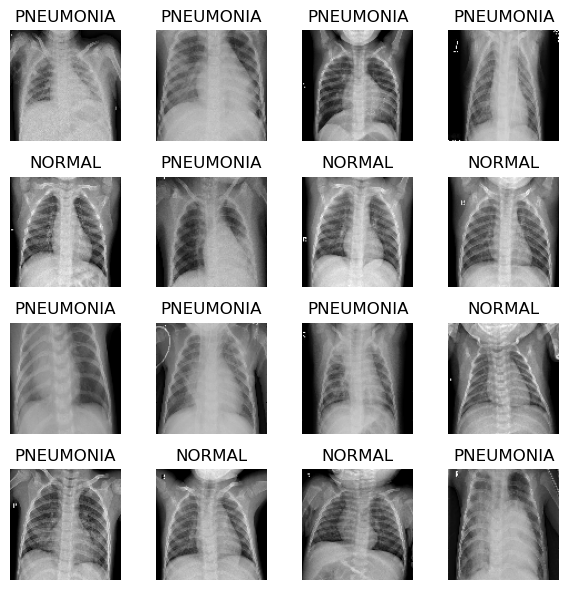

In [34]:
plt.figure(figsize = (6, 6))
class_dict = {0:'NORMAL', 1:'PNEUMONIA'}
for i in range(len(label)):
    plt.subplot(4, 4, i+1)
    plt.axis("off")
    plt.title(class_dict[label[i]])
    plt.imshow(data[i])
    
plt.tight_layout()

### Fine Tunning을 위한 pre-trained 정의 및 모델 구축

In [35]:
pre_trained_model = MobileNet(weights = "imagenet", include_top = False,
                             input_shape=(img_width, img_height, 3)) # 이미지넷에서 학습한 가중치를 사용
pre_trained_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 50, 50, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 50, 50, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 50, 50, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 50, 50, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 50, 50, 32)       128       
 ation)                                         

                                                                 
 conv_pw_8 (Conv2D)          (None, 6, 6, 512)         262144    
                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 6, 6, 512)        2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 6, 6, 512)         0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 6, 6, 512)        4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 6, 6, 512)        2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 6, 6, 512)         0         
                                                                 
 conv_pw_9

In [36]:
model = Sequential()
model.add(pre_trained_model)
model.add(GlobalAveragePooling2D()) # flatten 대신
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(train_generator.num_classes, activation = "softmax"))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 3, 3, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 128)               131200    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 2)                 258       
                                                                 
Total params: 3,360,322
Trainable params: 3,338,434
No

In [37]:
model.compile(loss = "sparse_categorical_crossentropy",
             optimizer = Adam(1e-5), metrics = ["acc"])

In [38]:
start_time = datetime.now()

result = model.fit(train_generator, epochs = 3, validation_data= val_generator)

end_time = datetime.now()
print("Elapsed Time : ", end_time - start_time)

Epoch 1/3
131/131 [==============================] - 68s 469ms/step - loss: 0.7632 - acc: 0.7172 - val_loss: 0.5304 - val_acc: 0.8130
Epoch 2/3
131/131 [==============================] - 62s 470ms/step - loss: 0.3468 - acc: 0.8687 - val_loss: 0.4610 - val_acc: 0.8332
Epoch 3/3
131/131 [==============================] - 62s 470ms/step - loss: 0.2451 - acc: 0.9106 - val_loss: 0.2626 - val_acc: 0.9003
Elapsed Time :  0:03:11.375048


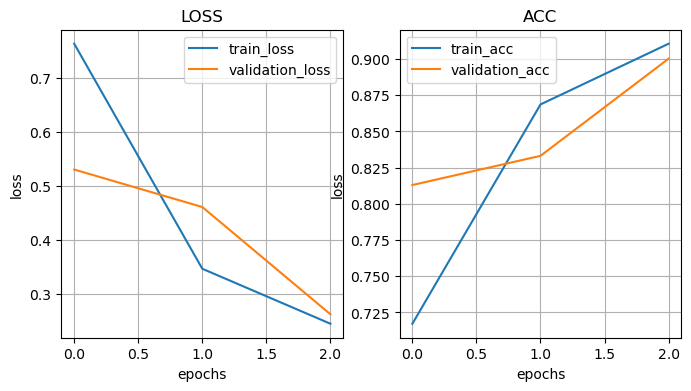

In [40]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label = "train_loss")
plt.plot(result.history["val_loss"], label = "validation_loss")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["acc"], label = "train_acc")
plt.plot(result.history["val_acc"], label = "validation_acc")
plt.legend(loc = "best")

In [39]:
model.evaluate(test_generator)

20/20 [==============================] - 5s 242ms/step - loss: 0.9597 - acc: 0.7115


[0.9596685767173767, 0.7115384340286255]

In [44]:
# 기존 validation 8개 데이터를 val, train데이터와 비교하는 용도로 사용
test_simple_data_gen = ImageDataGenerator(rescale = 1./255)

test_simple_generator = test_simple_data_gen.flow_from_directory(directory=val_data_root_dir,
                                  batch_size = 32, 
                                  target_size = (img_height, img_width),
                                  class_mode = "sparse",
                                  color_mode = "rgb")

Found 16 images belonging to 2 classes.


In [45]:
model.evaluate(test_simple_generator)

1/1 [==============================] - 0s 181ms/step - loss: 1.3599 - acc: 0.5625


[1.359854817390442, 0.5625]

# Project-2

### test, val 디렉토리의 모든 파일을 train 동일 디렉토리로 move

In [52]:
test_label_name_list = os.listdir(test_data_root_dir)
print(test_label_name_list)

['NORMAL', 'PNEUMONIA']


In [53]:
for label_name in test_label_name_list:
    test_path = os.path.join(test_data_root_dir, label_name)
    test_file_list = os.listdir(test_path)
    
    val_path = os.path.join(val_data_root_dir, label_name)
    val_file_list = os.listdir(val_path)
    
    train_path = os.path.join(train_data_root_dir, label_name)
    
    move_num = 0
    for test_file in test_file_list:
        shutil.move(os.path.join(test_path, test_file), os.path.join(train_path, test_file))
        move_num += 1

    print(str(move_num) + " is moved into " + label_name + \
         "(test => train)")
    
    move_num = 0
    for val_file in val_file_list:
        shutil.move(os.path.join(val_path, val_file), os.path.join(train_path, val_file))
        move_num += 1

    print(str(move_num) + " is moved into " + label_name + \
         "(val => train)")

316 is moved into NORMAL(test => train)
0 is moved into NORMAL(val => train)
0 is moved into PNEUMONIA(test => train)
0 is moved into PNEUMONIA(val => train)


### move 완료된 train 전체 데이터 갯수 확인

In [49]:
train_label_name_list = os.listdir(train_data_root_dir)

for label_name in train_label_name_list:
    print("train label :", label_name, ' =>',
          len(os.listdir(os.path.join(train_data_root_dir, label_name))))

train label : NORMAL  => 1583
train label : PNEUMONIA  => 4273


### Shuffle 후 다시 test, val 폴더로 move

In [55]:
### move할 파일의 비율
move_ratio = 0.2

label_name_list = os.listdir(train_data_root_dir)

for label_name in label_name_list:
    src = os.path.join(train_data_root_dir, label_name)
    dst = os.path.join(test_data_root_dir, label_name)
    
    train_data_file_list = os.listdir(src)
    
    
    print("===========================================")
    print("total [%s] data file nums => [%s]"%(label_name, 
                                               len(train_data_file_list)))
    
    np.random.shuffle(train_data_file_list)
    print("train data shuffle is done!")
    
    
    split_num = int(move_ratio*len(train_data_file_list))
    print("test split nums = ", split_num)
    
    test_data_file_list = train_data_file_list[0:split_num]
      
    
    move_num = 0
    for test_data_file in test_data_file_list:
        shutil.move(os.path.join(src, test_data_file),
                   os.path.join(dst, test_data_file))
        move_num += 1
        
    print("total move num => ", move_num)
    print("------------------------------------------")
    
    

total [NORMAL] data file nums => [1267]
train data shuffle is done!
test split nums =  253
total move num =>  253
------------------------------------------
total [PNEUMONIA] data file nums => [4273]
train data shuffle is done!
test split nums =  854
total move num =>  854
------------------------------------------


In [56]:
### 훈련데이터 갯수 
train_label_name_list = os.listdir(train_data_root_dir)

for label_name in train_label_name_list:
    print("train label :", label_name, ' =>',
          len(os.listdir(os.path.join(train_data_root_dir, label_name))))


print("==========================================================")
### 테스트 데이터 갯수
test_label_name_list = os.listdir(test_data_root_dir)

for label_name in train_label_name_list:
    print("test label :", label_name, ' =>',
          len(os.listdir(os.path.join(test_data_root_dir, label_name))))

train label : NORMAL  => 1014
train label : PNEUMONIA  => 3419
test label : NORMAL  => 569
test label : PNEUMONIA  => 854


In [57]:
train_data_gen = ImageDataGenerator(rescale = 1./255, validation_split=0.2)
val_data_gen = ImageDataGenerator(rescale = 1./255, validation_split=0.2)

test_data_gen = ImageDataGenerator(rescale = 1./255)

In [58]:
train_generator = train_data_gen.flow_from_directory(directory=train_data_root_dir,
                                  batch_size = 32, 
                                  target_size = (img_height, img_width),
                                  class_mode = "sparse",
                                  color_mode = "rgb",
                                    subset = "training") # train 폴더 설정

val_generator = val_data_gen.flow_from_directory(directory=train_data_root_dir, 
                                 batch_size = 32, 
                                 target_size = (img_height, img_width),
                                 class_mode = "sparse",
                                 color_mode = "rgb",
                                    subset = "validation") # validation폴더 설정

test_generator = test_data_gen.flow_from_directory(directory=test_data_root_dir, 
                                 batch_size = 32, 
                                 target_size = (img_height, img_width),
                                 class_mode = "sparse",
                                 color_mode = "rgb")



Found 3548 images belonging to 2 classes.
Found 885 images belonging to 2 classes.
Found 1423 images belonging to 2 classes.


In [59]:
pre_trained_model = MobileNet(weights = "imagenet", include_top = False,
                             input_shape=(img_width, img_height, 3)) # 이미지넷에서 학습한 가중치를 사용
pre_trained_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 50, 50, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 50, 50, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 50, 50, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 50, 50, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 50, 50, 32)       128       
 ation)                                         

                                                                 
 conv_pw_8 (Conv2D)          (None, 6, 6, 512)         262144    
                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 6, 6, 512)        2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 6, 6, 512)         0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 6, 6, 512)        4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 6, 6, 512)        2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 6, 6, 512)         0         
                                                                 
 conv_pw_9

In [60]:
model = Sequential()
model.add(pre_trained_model)
model.add(GlobalAveragePooling2D()) # flatten 대신
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(train_generator.num_classes, activation = "softmax"))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 3, 3, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_4   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 128)               131200    
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 2)                 258       
                                                                 
Total params: 3,360,322
Trainable params: 3,338,434
No

In [61]:
model.compile(loss = "sparse_categorical_crossentropy",
             optimizer = Adam(1e-5), metrics = ["acc"])

In [62]:
start_time = datetime.now()

result = model.fit(train_generator, epochs = 3, validation_data= val_generator)

end_time = datetime.now()
print("Elapsed Time : ", end_time - start_time)

Epoch 1/3
111/111 [==============================] - 56s 463ms/step - loss: 0.6565 - acc: 0.7249 - val_loss: 0.4508 - val_acc: 0.8249
Epoch 2/3
111/111 [==============================] - 50s 450ms/step - loss: 0.3584 - acc: 0.8554 - val_loss: 0.3718 - val_acc: 0.8588
Epoch 3/3
111/111 [==============================] - 51s 456ms/step - loss: 0.2574 - acc: 0.9030 - val_loss: 0.2622 - val_acc: 0.8915
Elapsed Time :  0:02:36.693518
